In [10]:
import os
import tensorflow as tf


print(os.path.isdir("/host/mask_rcnn"))

print(os.path.isdir("/host/my_models"))

print(os.path.isdir("/host/my_dataset_prod"))



True
True
True


In [11]:
import os

print(os.listdir("/host/my_dataset_train"))
print(os.listdir("/host/my_dataset_val"))

print(os.listdir("/host/my_models"))
print(os.listdir("/host/my_dataset_prod"))

['001.json', '001.png', '002.json', '002.png', '003.json', '003.png', '004.json', '004.png', '005.json', '005.png', '006.json', '006.png', '007.json', '007.png', '008.json', '008.png', '009.json', '009.png', '010.json', '010.png', '011.json', '011.png', '012.json', '012.png', '013.json', '013.png', '014.json', '014.png', '015.json', '015.png', '016.json', '016.png', '017.json', '017.png', '018.json', '018.png', '019.json', '019.png', '100.json', '100.png', '101.json', '101.png', '102.json', '102.png', '103.json', '103.png', '104.json', '104.png', '105.json', '105.png', '106.json', '106.png', '107.json', '107.png', '108.json', '108.png', '109.json', '109.png', '110.json', '110.png', '111.json', '111.png', '112.json', '112.png', '113.json', '113.png', '114.json', '114.png', '115.json', '115.png', '116.json', '116.png', '117.json', '117.png', '118.json', '118.png', '119.json', '119.png', '120.json', '120.png', '121.json', '121.png', '122.json', '122.png', '123.json', '123.png', '124.json'

In [12]:
# Importer les bibliothèques nécessaires
import os
import sys
import numpy as np
import mrcnn.model as modellib
import mrcnn.model as MaskRCNN
from mrcnn.config import Config
from mrcnn import utils

import json
import os
from pycocotools.coco import COCO

In [13]:
class CustomConfig(Config):
    NAME = "custom_model"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # 1 Background + 1 classe pour ton objet
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.7
    LEARNING_RATE = 1e-3


In [14]:
import json
import numpy as np
from PIL import Image, ImageDraw
import os
from mrcnn import utils

class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir):
        # Définir les classes (assurez-vous qu’elles sont correctement définies)
        self.add_class("dataset", 1, "sword")
        
        # Charger les images
        for i, filename in enumerate(os.listdir(dataset_dir)):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Ajustez selon les formats
                image_path = os.path.join(dataset_dir, filename)
                self.add_image(
                    "dataset",
                    image_id=i,
                    path=image_path,
                    # Ajouter les coordonnées si nécessaire
                )



In [15]:
# Créer la configuration
config = CustomConfig()
inference_config = config
inference_config.GPU_COUNT = 1  # Utilisez 1 GPU pour l'inférence
inference_config.IMAGES_PER_GPU = 1

# Initialiser le modèle
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir="logs/")

# Charger les poids COCO pré-entraînés
trained_model_path = "/host/my_models/mask_rcnn_custom_model_0028.h5"  # Remplacez par le chemin exact de votre fichier
model.load_weights(trained_model_path, by_name=True)


In [37]:
dataset_prod = CustomDataset()
dataset_prod.load_custom("/host/my_dataset_prod")  # Chemin vers les images de production
dataset_prod.prepare()

In [38]:
print("Nombre d'images dans le dataset de production :", len(dataset_prod.image_ids))

Nombre d'images dans le dataset de production : 5


Processing 1 images
image                    shape: (1047, 594, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1047.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Épée détectée avec une confiance de 87.45577931404114%
Épée détectée avec une confiance de 81.48135542869568%
Épée détectée avec une confiance de 75.38832426071167%


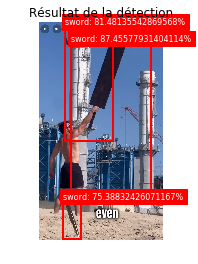

In [40]:
import matplotlib.pyplot as plt

# Définir l'index de la classe correspondant à une "épée" dans votre configuration
# Assurez-vous que l'index "class_id" pour "épée" correspond bien dans votre CustomDataset
SWORD_CLASS_ID = 1  # Remplacez par l'ID réel de la classe "épée" dans votre dataset

# Sélectionner une image de production
image_id = dataset_prod.image_ids[4]  # Utilise le premier ID d'image du dataset
image = dataset_prod.load_image(image_id)

# Faire une prédiction avec le modèle
results = model.detect([image], verbose=1)
r = results[0]

# Afficher l'image
plt.imshow(image)
plt.title("Résultat de la détection")
plt.axis("off")

# Parcourir chaque objet détecté
for i, bbox in enumerate(r['rois']):
    y1, x1, y2, x2 = bbox
    class_id = r['class_ids'][i]
    score = r['scores'][i]
    label = dataset_prod.class_names[class_id]  # Récupère le nom de la classe détectée

    # Affiche la bounding box
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2))

    # Affiche le pourcentage de confiance
    plt.text(x1, y1, "{}: {}%".format(label, score * 100), color="white", backgroundcolor="red", fontsize=8)

    # Affiche un message si une épée est détectée
    if class_id == SWORD_CLASS_ID:
        print("Épée détectée avec une confiance de {}%".format(score * 100))

plt.show()
